# DAT405 Introduction to Data Science and AI 
## Assignment 4: Spam classification using Naïve Bayes 

### Francisco Boudagh
### Jakob Engström
### 2023-04-26

The three folders containing emails are downloaded manually.

### 1. Preprocessing

##### 1.1 Look at a few emails from easy_ham, hard_ham and spam. Do you think you would be able to classify the emails just by inspection? How do you think a succesful model can learn the difference between the different classes of emails?


In [23]:
import email.policy
from email import message_from_string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def extract_emails(file, class_name):
  emails_list = []
  for directory in file:
    for file in os.listdir(directory):
      with open(os.path.join(directory,file), encoding='latin-1') as f:
        if f:
          content = f.read()
          emails_list.append({'email': message_from_string(content, policy=email.policy.default), 'content': content, 'class': class_name})
  return pd.DataFrame(emails_list)

# extract emails and add class information
df_eh = extract_emails(['easy_ham'], 'eham')
df_hh = extract_emails(['hard_ham'], 'hham')
df_s = extract_emails(['spam'], 'spam')

# combining easy ham, hard ham and spam
df_combined = pd.concat([df_eh, df_hh, df_s])

print('Easy ham:', + len(df_eh))
print('Hard ham:', + len(df_hh))
print('Spam:', + len(df_s))

pd.set_option('max_colwidth',4500)

# printing some spam samples to find patterns manually
df_s.sample(5)

Easy ham: 2551
Hard ham: 250
Spam: 501


email  \
93                                                                       [Return-Path, Delivered-To, Received, Received, Received, Message-Id, From, To, Cc, Subject, Sender, MIME-Version, Date, X-Mailer, Content-Type]   
274                              [Return-Path, Delivered-To, Received, Received, Received, Received, Received, Message-Id, Date, From, Reply-To, To, Subject, MIME-Version, X-Ema-Cid, X-Ema-Lid, X-Ema-PC, Content-Type]   
71   [Return-Path, Delivered-To, Received, Received, Received, From, Reply-To, Message-ID, To, Subject, Date, MiME-Version, Content-Type, X-Priority, X-MSMail-Priority, X-Mailer, Importance, Content-Transfer-Encoding]   
352                                                                   [Return-Path, Delivered-To, Received, Received, Received, Message-Id, Errors-To, From, Organisation, To, Subject, Date, MIME-Version, Content-Type]   
165           [Return-Path, Delivered-To, Received, Received, Received, Message-Id, From, Reply-To, To, Date, Subject, X-Priority, X-Mailer, MIME-Version, Content-Type, X-MIME-Autoconverted, Content-Transfer-Encoding]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

#### Answer 1.1:
We can see that spam mails fearue a lot of cursive and bold letters, mainly in black and red. A reocurring theme is money. So yes, some of the mails are quite easy for us to classify. If given a big amount of test data a model could probably diferentiate spam from ham quite easily. Som of the indicators could be as written before, the color and type of text. Another indicator could be to look after some reoucurring words and phrase such as 'money', 'bitcoin' and such. Also looking at the content and determining wether all the words are in a common dictionary or not since random letter combinations are reocurring in these spam mails.


##### 1.2 Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text (in the optional part further down can experiment with filtering out the headers and footers). We don’t want to train and test on the same data (it might help to reflect on why if you don't recall). Split the spam and the ham datasets in a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`). Use only the easy_ham part as ham data for quesions 1 and 2.

In [19]:
from sklearn.model_selection import train_test_split

df_eh = extract_emails(['easy_ham'], 'eham')
df_s = extract_emails(['spam'], 'spam')

# join the two dataframes only for easy_ham and spam as instructions
df_combined_eh_s = pd.concat([df_eh, df_s])

X = df_combined_eh_s['content']
y = df_combined_eh_s['class']

# splitting training data, train size: 65%, test size: 35%
hamtrain, hamtest, spamtrain, spamtest = train_test_split(X, y, train_size=0.65)

# create new dataframes for each set'
hamtrain = pd.DataFrame({'content': hamtrain, 'class': hamtrain})
hamtest = pd.DataFrame({'content': hamtest, 'class': hamtest})
spamtrain = pd.DataFrame({'content': spamtrain, 'class': spamtrain})
spamtest = pd.DataFrame({'content': spamtest, 'class': spamtest})

### 2.1 Write a Python program that: 
##### 1.	Uses the four datasets from Question 1 (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`) 

##### 2.	Trains a Naïve Bayes classifier (use the [scikit-learn library](https://scikit-learn.org/stable/)) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. Use `CountVectorizer` ([Documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)) to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifier in scikit-learn ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Test two of these classifiers that are well suited for this problem:
##### - Multinomial Naive Bayes  
##### - Bernoulli Naive Bayes. 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

# cm labels
categories= ["Spam", "Ham"]
group_names = ['True ham','False spam','False ham','True spam']

def spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, groupnames, cm_title, classifier):
    vectorizer = CountVectorizer()
    hamtrain = vectorizer.fit_transform(hamtrain)
    hamtest = vectorizer.transform(hamtest)

    if classifier == 'MNB':
        model = MultinomialNB()
    elif classifier == 'BNB':
        model = BernoulliNB()
    else:
        raise ValueError("Invalid classifier type. Please choose either 'MNB' or 'BNB'.")

    # fit train data into the chosen model
    model.fit(hamtrain, spamtrain)

    # accuracy score in %
    accuracy = model.score(hamtest, spamtest) * 100
    print("Accuracy of this model is: {:.2f}%".format(accuracy))

    spam_test_pred = model.predict(hamtest)
    cm = confusion_matrix(spamtest, spam_test_pred)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    df_cm = pd.DataFrame(cm, range(2), range(2))

    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = sns.heatmap(df_cm, annot=True, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    ax.set_title(cm_title)
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    plt.show()

Accuracy of this model is: 97.01%


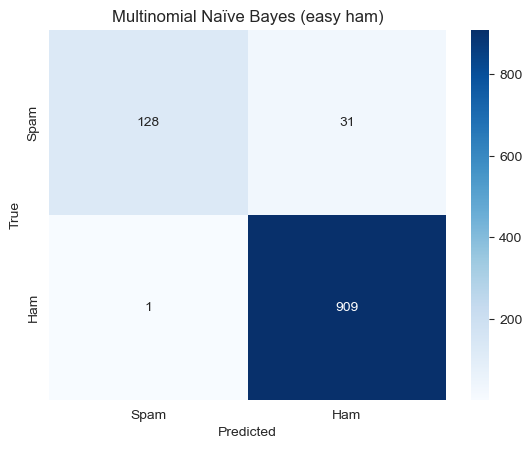

Accuracy of this model is: 92.14%


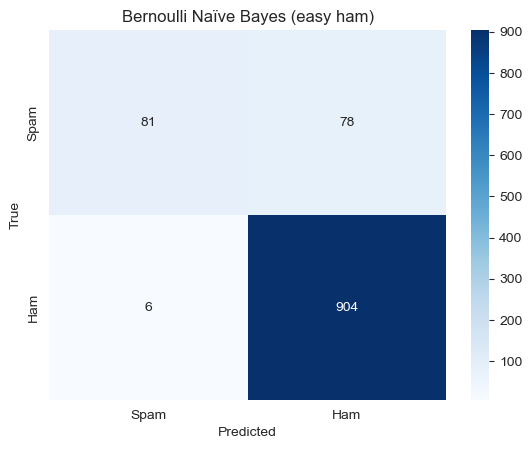

In [12]:
df_ham_spam = pd.concat([df_eh, df_s])

# spam = 1 and ham = 0
df_ham_spam.loc[df_ham_spam['class'] == 'spam', 'class'] = 1
df_ham_spam.loc[df_ham_spam['class'] == 'ham', 'class'] = 0

# create datasets with 65& train size and 35% test size
hamtrain, hamtest, spamtrain, spamtest = train_test_split(df_ham_spam['content'], df_ham_spam['class'].values.tolist(), train_size=0.65)

spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Multinomial Naïve Bayes (easy ham)", 'MNB')
spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Bernoulli Naïve Bayes (easy ham)", 'BNB')

### 2.2 Answer the following questions:
##### a) What does the CountVectorizer do?
The function CountVectorizer transforms text into numerical matrix by first splitting the words and then counting their frequency. This is since we need numerical values inorder to use the classsfiers.

##### b) What is the difference between Multinomial Naive Bayes and Bernoulli Naive Bayes
Bernoulli Naive Bayes is a binary model. It only sees if a word (from trained dataset) exists (in test mail) or not (so it will give a value, 0 or 1), while Multinomial count the reoucurrance of each word, which normalized would be a value from 0 to 1. So it is reasonable (as the result above show) that Multinomial would perform better in this case since the data represents words.

### 3.1 Run the two models:
##### Run (don't retrain) the two models from Question 2 on spam versus hard-ham. Does the performance differ compared to question 2 when the model was run on spam versus easy-ham? If so, why?

Accuracy of this model is: 91.63%


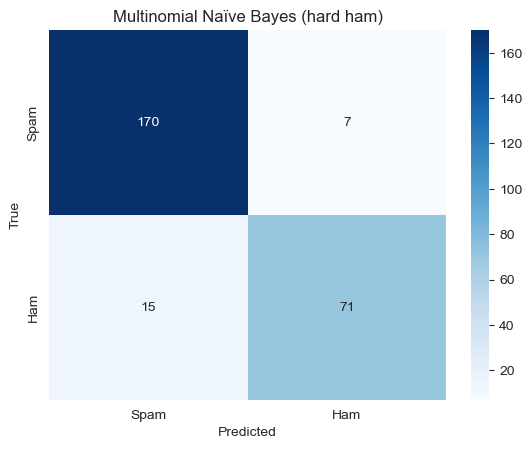

Accuracy of this model is: 88.21%


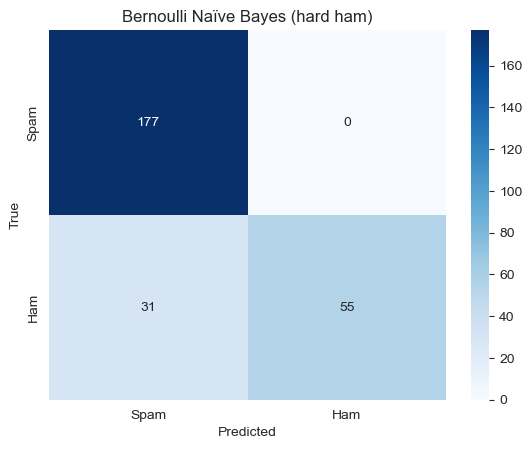

In [13]:
df_ham_spam = pd.concat([df_hh, df_s])

# spam = 1 and ham = 0
df_ham_spam.loc[df_ham_spam['class'] == 'spam', 'class'] = 1
df_ham_spam.loc[df_ham_spam['class'] == 'ham', 'class'] = 0

# Create datasets with 65& train size and 35% test size
hamtrain, hamtest, spamtrain, spamtest = train_test_split(df_ham_spam['content'], df_ham_spam['class'].values.tolist(), train_size=0.65)

spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Multinomial Naïve Bayes (hard ham)", 'MNB')
spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Bernoulli Naïve Bayes (hard ham)", 'BNB')

#### Answer 3.1:
Yes. Both the models now have less accuracy than the one in question 2. This is because this model is trying to detect spam in hard ham which is harder to differentiate from spam.

### 3.2 Retrain
##### Retrain new Multinomial and Bernolli Naive Bayes classifers on the combined (easy+hard) ham and spam. Now evaluate on spam versus hard-ham as in 3.1. Also evaluate on spam versus easy-ham. Compare the performance with question 2 and 3.1. What do you observe?

Accuracy of this model is: 95.82%


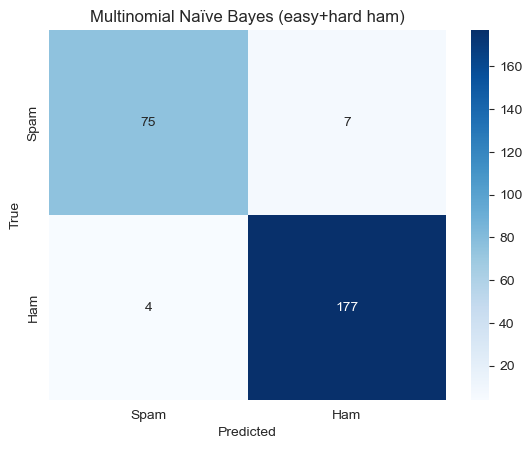

Accuracy of this model is: 88.97%


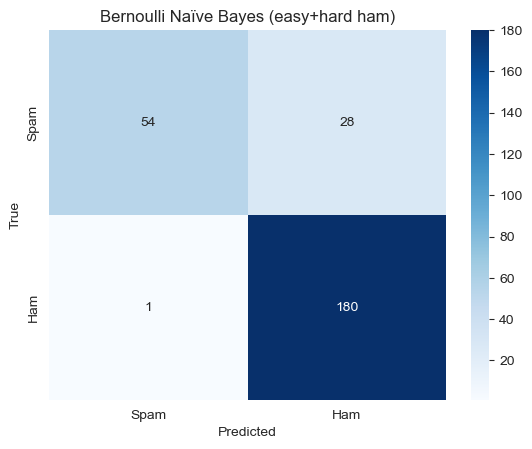

In [14]:
df_h = extract_emails(['easy_ham'] and ['hard_ham'], 'ham')

df_ham_spam = pd.concat([df_h, df_s])

# spam = 1 and ham = 0
df_ham_spam.loc[df_ham_spam['class'] == 'spam', 'class'] = 1
df_ham_spam.loc[df_ham_spam['class'] == 'ham', 'class'] = 0

# Create datasets with 65& train size and 35% test size
hamtrain, hamtest, spamtrain, spamtest = train_test_split(df_ham_spam['content'], df_ham_spam['class'].values.tolist(), train_size=0.65)

spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Multinomial Naïve Bayes (easy+hard ham)", 'MNB')
spam_detection_cm(hamtrain, hamtest, spamtrain, spamtest, categories, group_names, "Bernoulli Naïve Bayes (easy+hard ham)", 'BNB')

#### Answer 3.2:

The accuracy for the combined model becomes lower than for the one trained and tested on only easy ham but higher for the one tested with hard ham, for both classifiers. We are getting higher accuracy of the combined than the only hard ham because now we have a lot of mails that are easy ham, and the model is also trained by a larger dataset. The combined have less accuracy than the one trained and tested for easy ham because now we also have mails that are harder to detect as spam.

### 3.3 Further improvements

#### Answer 3.3: 
The above models mainly rely on counting words. If we somehow inlcuded more parameters to the model such as detect the letter colors, font style (bold and cursive) and look after emojis since this is recurring in spam mails (by experience). 😅😜👾😈🥳😂